<a href="https://colab.research.google.com/github/gcfc/academic_projects/blob/main/6_881_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Geometric Approach to Recycling Cans via Vision-Based Manipulation
### 6.881 Final Project 
#### George Chen, Susan Ni 

This project demonstrates the full manipulation pipeline taught in MIT 6.881 Robot Manipulation. There are notes within the code indicating where it was adapted from if applicable. 

<b><font color='green'>To run the simulation</font></b>:
- Download the two SDF files [here](https://drive.google.com/drive/folders/1NKjct851-_GWZS2cdOsrkOrWvvxiyzOL?usp=sharing) and upload them to this notebook.
- Run [Notebook Setup](https://colab.research.google.com/drive/1YcCZiwTrMGF67JR2YzF5zp4o3HmtLu72?authuser=1#scrollTo=rF6_3STtq8DA), [Project Class](https://colab.research.google.com/drive/1YcCZiwTrMGF67JR2YzF5zp4o3HmtLu72?authuser=1#scrollTo=l-y1owXtmPB7&line=1&uniqifier=1), and all cells within [Perception (<b>multi can</b>)](https://colab.research.google.com/drive/1YcCZiwTrMGF67JR2YzF5zp4o3HmtLu72?authuser=1#scrollTo=xghXBT6h91CY&line=1&uniqifier=1) sequentially.
- Under [Motion Planning](https://colab.research.google.com/drive/1YcCZiwTrMGF67JR2YzF5zp4o3HmtLu72?authuser=1#scrollTo=ez_hSv7_zz_r) section, run first two cells sequentially. The second cell will output a link to meshcat to visualize the simulation environment.
- Run the [last cell](https://colab.research.google.com/drive/1YcCZiwTrMGF67JR2YzF5zp4o3HmtLu72?authuser=1#scrollTo=vlEV5BKc3MZK&line=2&uniqifier=1) of the 'Motion Planning' section to run the simulation.

Additional Notes:
-  The [Perception (single can)](https://colab.research.google.com/drive/1YcCZiwTrMGF67JR2YzF5zp4o3HmtLu72?authuser=1#scrollTo=HSA69xRe1VXL&line=1&uniqifier=1) section demonstrates using anitpodal normals as a heuristic for generating grasp candidates. It can be visualized by running the 'Notebook Setup', 'Project Class', and 'Perception (single can)' sections sequentially. The first cell under the 'Perception (single can)' section outputs the meshcat link. However, there are <b>issues with running a perception section twice in a row</b>. If you want to run a perception section again, start by running cell sequentially from the very beginning of the notebook again.

###Notebook Setup###
The following cell will install Drake, checkout the manipulation repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  

More details are available [here](http://manipulation.mit.edu/drake.html).

In [ ]:
import importlib
import os, sys
from urllib.request import urlretrieve

if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='master', drake_version='20201130', drake_build='nightly')

# setup ngrok server
server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']

# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

# Setup rendering (with xvfb):
import os
if 'google.colab' in sys.modules and os.getenv("DISPLAY") is None:
    from pyvirtualdisplay import Display
    d = Display(visible=0, size=(1400, 900))
    d.start()

# Python imports
import numpy as np
import pydrake
from pydrake.all import *
import matplotlib.pyplot as plt
from copy import deepcopy
import open3d as o3d
import meshcat.geometry as g
import cv2

# Determine if this notebook is currently running as a notebook or a unit test.
from IPython import get_ipython
running_as_notebook = get_ipython() and hasattr(get_ipython(), 'kernel')

# other
from pydrake.examples.manipulation_station import ManipulationStation, IiwaCollisionModel
from pydrake.systems.jupyter_widgets import PoseSliders, WidgetSystem
from ipywidgets import ToggleButton, ToggleButtons
from manipulation.scenarios import AddRgbdSensors
from manipulation.utils import FindResource
from manipulation.open3d_utils import create_open3d_point_cloud
from pydrake.multibody import inverse_kinematics
from pydrake.trajectories import PiecewisePolynomial
from manipulation.exercises.trajectories.rrt_planner.rrt_planning import Problem
from manipulation.exercises.trajectories.rrt_planner.robot import Range, ConfigurationSpace
from IPython.display import display, HTML, SVG
from random import random
import time

### Project Class ###
#### with helper functions for adding elements to scene and setting up different simulation environments ####

Descriptions of the environments:
- `slider_environment`: was used during initial simulation environment setup. The arm/gripped can be controlled via teleop to ensure contact geometry of the scene objects, physics, etc. are behaving correctly.
- `plain_environment`: has front and back cameras and is used for antipodal grasping with a single object on the plate only.
- `multi_object_environment`: has top camera only and is used for calculating grasp/pregrasp poses with multiple objects on the plate to be fed to the motion planning system. (i.e. used for perception)
- `build_and_simulate_trajectory_environment`: to be used once the motion planning system outputs trajectories for the arm/gripper to follow. Has to have the same object positions as `multi_object_environment` in order to function as intended. (i.e. used to visualize motion planning based on the perception run in the `multi_object_environment`)

In [ ]:
class Project:
    def __init__(self):
        # camera images in form of self.{location}_rgb_im and self.{location}_depth_im
        # i.e. for camera_top, self.top_rgb_im and self.top_depth_im

        self.top_cam_pose = RigidTransform(RollPitchYaw(-np.pi, 0, np.pi/2), [-0.5, 0, 0.75])  # X_WC
        self.front_cam_pose = RigidTransform(RotationMatrix.MakeXRotation(-np.pi + np.pi/4), [-0.5, -0.65, 0.55])  # X_WC from front
        self.back_cam_pose = RigidTransform(RollPitchYaw(-np.pi + np.pi/4, 0, np.pi), [-0.5, 0.65, 0.55])  # X_WC from back
        self.cam_info = CameraInfo(848, 480, 616.285, 615.778, 405.418, 232.864)

    def set_up_station(self, station, plant, parser):
        '''
        Adds an iiwa (box collision model), wsg, and a camera.
        Effectively replacing station.SetUpCutterClearingStation()
        Adapted from: https://github.com/RobotLocomotion/drake/blob/master/bindings/pydrake/examples/test/manipulation_station_test.py
        station: i.e what's returned from builder.AddSystem(ManipulationStation())
        plant: i.e. from station.get_mutable_multibody_plant()
        parser: i.e. Parser(plant, station.get_mutable_scene_graph())
        '''
        # Add model for iiwa.
        iiwa_model_file = FindResourceOrThrow(
            "drake/manipulation/models/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf")
        iiwa = parser.AddModelFromFile(iiwa_model_file, "iiwa")
        X_WI = RigidTransform.Identity()
        plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0", iiwa), X_WI)

        # Add model for wsg.
        wsg_model_file = FindResourceOrThrow(
            "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf")
        wsg = parser.AddModelFromFile(wsg_model_file, "gripper")
        X_7G = RigidTransform(RollPitchYaw(np.pi/2, 0, np.pi/2), np.array([0, 0, 0.114]))
        plant.WeldFrames(
            plant.GetFrameByName("iiwa_link_7", iiwa),
            plant.GetFrameByName("body", wsg),
            X_7G)

        # Register models for the controller.
        station.RegisterIiwaControllerModel(
            iiwa_model_file, iiwa, plant.world_frame(),
            plant.GetFrameByName("iiwa_link_0", iiwa), X_WI)
        station.RegisterWsgControllerModel(
            wsg_model_file, wsg,
            plant.GetFrameByName("iiwa_link_7", iiwa),
            plant.GetFrameByName("body", wsg), X_7G)
        
        # Add camera.
        self.add_top_camera(station, plant, parser)
        # self.add_two_cameras(station, plant, parser)

    def add_two_cameras(self, station, plant, parser):
        '''
        Adds a camera in front of and behind litter plate.
        '''
        front_color_camera, front_depth_camera = self.make_camera_model()
        station.RegisterRgbdSensor("front", plant.world_frame(), self.front_cam_pose, front_color_camera, front_depth_camera)
        camera_front = parser.AddModelFromFile(FindResource("models/camera_box.sdf"), "camera_front")
        plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base", camera_front), self.front_cam_pose)

        back_color_camera, back_depth_camera = self.make_camera_model()
        station.RegisterRgbdSensor("back", plant.world_frame(), self.back_cam_pose, back_color_camera, back_depth_camera)
        camera_back = parser.AddModelFromFile(FindResource("models/camera_box.sdf"), "camera_back")
        plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base", camera_back), self.back_cam_pose)

    def add_top_camera(self, station, plant, parser):
        '''
        Adds a camera above the center of the litter plate.
        '''
        color_camera, depth_camera = self.make_camera_model()
        station.RegisterRgbdSensor("top", plant.world_frame(), self.top_cam_pose, color_camera, depth_camera)
        top_camera = parser.AddModelFromFile(FindResource("models/camera_box.sdf"), "camera_top")
        plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base", top_camera), self.top_cam_pose)
        
    def make_camera_model(self):
        '''
        Adapted from: https://github.com/RobotLocomotion/drake/blob/master/examples/manipulation_station/manipulation_station.cc#L156
        '''
        color_camera = ColorRenderCamera(
            RenderCameraCore("manip_station_renderer",
                            self.cam_info,
                            ClippingRange(0.01, 10.0),
                            RigidTransform()),
                            False)
        depth_camera = DepthRenderCamera(color_camera.core(), DepthRange(0.1, 9.5))
        return color_camera, depth_camera

    def set_up_litter_plate(self, plant, parser):
        '''
        Adds a flat plate to the scene. (to hold cans to be recycled)
        return: ModelInstanceIndex of plate
        ''' 
        plate_index = parser.AddModelFromFile("/content/flat_box.sdf")
        X_WC = RigidTransform(RotationMatrix.Identity(), [-0.5, 0, 0])
        plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base_link", plate_index), X_WC)
        
    def set_up_bin(self, plant, parser):
        '''
        Adds a bin to the scene. (where recyclable cans should be placed)
        Adapted from: https://github.com/RobotLocomotion/drake/blob/master/examples/manipulation_station/manipulation_station.cc
        '''
        bin_model_file = FindResourceOrThrow("drake/examples/manipulation_station/models/bin.sdf");
        X_WC = RigidTransform(RotationMatrix.Identity(), np.array([1, 0, 0]))
        bin = parser.AddModelFromFile(bin_model_file, "bin")
        plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("bin_base", bin), X_WC)

    # TODO(susanni): when trying to use the coke can model from Gazebo -- RuntimeError: The Wavefront obj file has no faces.
    def add_coke_can(self, plant, parser, num=0):
        '''
        return: BodyIndex of coke can
        '''
        # model_index = parser.AddModelFromFile("/content/coke_can/model_new.sdf");
        # Reference: https://github.com/RobotLocomotion/drake/blob/master/examples/manipulation_station/manipulation_station.cc#L177
        model_index = parser.AddModelFromFile("/content/can.sdf", "cylinder"+str(num))
        indices = plant.GetBodyIndices(model_index)
        return indices[0]

    def slider_environment(self):
        '''
        Adapted from introduction colab from chapter 1: http://manipulation.csail.mit.edu/intro.html#example1
        '''
        builder = DiagramBuilder()

        # ------ station setup ------
        station = builder.AddSystem(ManipulationStation())
        plant = station.get_mutable_multibody_plant()
        parser = Parser(plant, station.get_mutable_scene_graph())

        self.set_up_station(station, plant, parser)
        self.set_up_bin(plant, parser)
        self.set_up_litter_plate(plant, parser)

        # litter.
        can_index = self.add_coke_can(plant, parser)

        station.Finalize()
        # ---------------------------

        meshcat = ConnectMeshcatVisualizer(
            builder,
            station.get_scene_graph(),
            output_port=station.GetOutputPort("pose_bundle"),
            zmq_url=zmq_url)

        robot = station.get_controller_plant()
        params = DifferentialInverseKinematicsParameters(robot.num_positions(), robot.num_velocities())

        time_step = 0.005
        params.set_timestep(time_step)
        # True velocity limits for the IIWA14 (in rad, rounded down to the first decimal)
        iiwa14_velocity_limits = np.array([1.4, 1.4, 1.7, 1.3, 2.2, 2.3, 2.3])
        params.set_joint_velocity_limits((-iiwa14_velocity_limits, iiwa14_velocity_limits))

        differential_ik = builder.AddSystem(pydrake.manipulation.planner.DifferentialInverseKinematicsIntegrator(
            robot, robot.GetFrameByName("iiwa_link_7"), time_step, params))
        builder.Connect(differential_ik.get_output_port(), station.GetInputPort("iiwa_position"))

        teleop = builder.AddSystem(PoseSliders(
            min_range = PoseSliders.MinRange(roll=0, pitch=-0.5, yaw=-np.pi, x=-0.6, y=-0.8, z=0.0),
            max_range = PoseSliders.MaxRange(roll=2*np.pi, pitch=np.pi, yaw=np.pi, x=0.8, y=0.3, z=1.1)
        ))
        builder.Connect(teleop.get_output_port(0), differential_ik.get_input_port())

        wsg_buttons = ToggleButtons(value=0.107, description="SchunkWsg", options=[('Open', 0.107), ('Close', 0.002)])
        wsg_teleop = builder.AddSystem(WidgetSystem([wsg_buttons]))
        builder.Connect(wsg_teleop.get_output_port(0), station.GetInputPort("wsg_position"))

        diagram = builder.Build()
        simulator = Simulator(diagram)  # allows for collision geometry and physics

        context = simulator.get_mutable_context()
        station_context = station.GetMyMutableContextFromRoot(context)

        plant.SetFreeBodyPose(  # setting pose for coke can
            station_context, plant.get_body(can_index),
            RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.4, 0.09]))

        q0 = station.GetOutputPort("iiwa_position_measured").Eval(station_context)
        differential_ik.get_mutable_parameters().set_nominal_joint_position(q0)
        diff_ik_context = differential_ik.GetMyMutableContextFromRoot(context)
        differential_ik.SetPositions(diff_ik_context, q0)
        teleop.SetPose(differential_ik.ForwardKinematics(diff_ik_context))

        meshcat.load()

        self.top_rgb_im = station.GetOutputPort('camera_top_rgb_image').Eval(station_context).data
        self.top_depth_im = station.GetOutputPort('camera_top_depth_image').Eval(station_context).data.squeeze()

        if running_as_notebook:  # Then we're not just running as a test on CI.
            simulator.set_target_realtime_rate(1.0)

            # Open the meshcat visualizer window (check your pop-up blocker).
            # open_window(visualizer.vis.url(), "meshcat")
            
            stop_button = ToggleButton(value=False, description='Stop Simulation')
            display(stop_button)
            while not stop_button.value:
                simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)

            stop_button.value = False
          
        else:
            simulator.AdvanceTo(0.1)
    
    def plain_environment(self):
        '''
        Has all elements in the scene but no way to move arm.
        Mostly for testing using front/back cameras with single can in scene.
        '''
        builder = DiagramBuilder()

        # ------ station setup ------
        station = builder.AddSystem(ManipulationStation())
        plant = station.get_mutable_multibody_plant()
        parser = Parser(plant, station.get_mutable_scene_graph())

        self.set_up_station(station, plant, parser)
        self.add_two_cameras(station, plant, parser)  # adding front and back cameras.
        self.set_up_bin(plant, parser)
        self.set_up_litter_plate(plant, parser)

        # litter.
        can_index = self.add_coke_can(plant, parser)

        station.Finalize()
        # ---------------------------

        meshcat = ConnectMeshcatVisualizer(
            builder,
            station.get_scene_graph(),
            output_port=station.GetOutputPort("pose_bundle"),
            zmq_url=zmq_url)

        diagram = builder.Build()
        simulator = Simulator(diagram)  # allows for collision geometry and physics

        context = simulator.get_mutable_context()
        station_context = station.GetMyMutableContextFromRoot(context)

        plant.SetFreeBodyPose(  # setting pose for coke can
            station_context, plant.get_body(can_index),
            RigidTransform(RollPitchYaw(-np.pi/2+4*np.pi/12, np.pi/2, 0), [-0.6, 0.2, 0.09]))

        meshcat.load()
        simulator.AdvanceTo(0.1)

        self.top_rgb_im = station.GetOutputPort('camera_top_rgb_image').Eval(station_context).data
        self.top_depth_im = station.GetOutputPort('camera_top_depth_image').Eval(station_context).data.squeeze()
        self.front_rgb_im = station.GetOutputPort('camera_front_rgb_image').Eval(station_context).data
        self.front_depth_im = station.GetOutputPort('camera_front_depth_image').Eval(station_context).data.squeeze()
        self.back_rgb_im = station.GetOutputPort('camera_back_rgb_image').Eval(station_context).data
        self.back_depth_im = station.GetOutputPort('camera_back_depth_image').Eval(station_context).data.squeeze()

        return meshcat.vis

    def multi_object_environment(self):
        '''
        Has all elements in the scene but no way to move arm.
        Mostly testing using top camera with multiple cans in scene.
        '''
        builder = DiagramBuilder()

        # ------ station setup ------
        station = builder.AddSystem(ManipulationStation())
        plant = station.get_mutable_multibody_plant()
        parser = Parser(plant, station.get_mutable_scene_graph())

        self.set_up_station(station, plant, parser)
        self.set_up_bin(plant, parser)
        self.set_up_litter_plate(plant, parser)

        # litter.
        can_index = self.add_coke_can(plant, parser)
        can_index2 = self.add_coke_can(plant, parser, 1)
        can_index3 = self.add_coke_can(plant, parser, 2)

        station.Finalize()
        # ---------------------------

        meshcat = ConnectMeshcatVisualizer(
            builder,
            station.get_scene_graph(),
            output_port=station.GetOutputPort("pose_bundle"),
            zmq_url=zmq_url)

        diagram = builder.Build()
        simulator = Simulator(diagram)  # allows for collision geometry and physics

        context = simulator.get_mutable_context()
        station_context = station.GetMyMutableContextFromRoot(context)

        plant.SetFreeBodyPose(  # setting pose for coke can
            station_context, plant.get_body(can_index),
            RigidTransform(RollPitchYaw(-np.pi/2+4*np.pi/12, np.pi/2, 0), [-0.6, 0.2, 0.09]))
        plant.SetFreeBodyPose(
            station_context, plant.get_body(can_index2),
            RigidTransform(RollPitchYaw(-7*np.pi/12, np.pi/2, 0), [-0.55, -0.05, 0.09]))
        plant.SetFreeBodyPose(
            station_context, plant.get_body(can_index3),
            RigidTransform(RollPitchYaw(0, 0, 0), [-0.3, -0.25, 0.09]))

        meshcat.load()
        simulator.AdvanceTo(0.1)

        gripper = plant.GetBodyByName("body")
        initial_pose = plant.EvalBodyPoseInWorld(plant.CreateDefaultContext(), gripper)
        print("initial pose trans:", initial_pose.translation())

        self.top_rgb_im = station.GetOutputPort('camera_top_rgb_image').Eval(station_context).data
        self.top_depth_im = station.GetOutputPort('camera_top_depth_image').Eval(station_context).data.squeeze()
        
        return meshcat.vis, initial_pose

    def build_and_simulate_trajectory_environment(self,q_traj, g_traj):
        """
        Simulate trajectory for manipulation station.
        To be used in conjusction with `multi_object_environment`.
        Adapted from `door_opening.ipynb` pset.
        :param q_traj: Trajectory class used to initialize TrajectorySource for joints.
        :param g_traj: Trajectory class used to initialize TrajectorySource for gripper.
        """
        builder = DiagramBuilder()

        # ------ station setup ------
        station = builder.AddSystem(ManipulationStation())
        plant = station.get_mutable_multibody_plant()
        parser = Parser(plant, station.get_mutable_scene_graph())

        self.set_up_station(station, plant, parser)
        self.set_up_bin(plant, parser)
        self.set_up_litter_plate(plant, parser)

        # litter.
        can_index = self.add_coke_can(plant, parser)
        can_index2 = self.add_coke_can(plant, parser, 1)
        can_index3 = self.add_coke_can(plant, parser, 2)

        station.Finalize()
        # ---------------------------

        q_traj_system = builder.AddSystem(TrajectorySource(q_traj))
        g_traj_system = builder.AddSystem(TrajectorySource(g_traj))

        meshcat = ConnectMeshcatVisualizer(builder,
                station.get_scene_graph(),
                output_port=station.GetOutputPort("pose_bundle"),
                delete_prefix_on_load=True,
                frames_to_draw={"gripper":{"body"}},
                zmq_url=zmq_url)
        
        builder.Connect(q_traj_system.get_output_port(),
                        station.GetInputPort("iiwa_position"))
        builder.Connect(g_traj_system.get_output_port(),
                        station.GetInputPort("wsg_position"))

        diagram = builder.Build()
        simulator = Simulator(diagram)

        context = simulator.get_mutable_context()
        station_context = station.GetMyMutableContextFromRoot(context)

        # !! Have to be the same as the can poses in `multi_object_environment` !!
        plant.SetFreeBodyPose(  # setting pose for coke can
            station_context, plant.get_body(can_index),
            RigidTransform(RollPitchYaw(-np.pi/2+4*np.pi/12, np.pi/2, 0), [-0.6, 0.2, 0.09]))
        plant.SetFreeBodyPose(
            station_context, plant.get_body(can_index2),
            RigidTransform(RollPitchYaw(-7*np.pi/12, np.pi/2, 0), [-0.55, -0.05, 0.09]))
        plant.SetFreeBodyPose(
            station_context, plant.get_body(can_index3),
            RigidTransform(RollPitchYaw(0, 0, 0), [-0.3, -0.25, 0.09]))

        meshcat.load()
        simulator.set_target_realtime_rate(10.0)  # speed up simulation x10.
        simulator.AdvanceTo(0.01)

        self.top_rgb_im = station.GetOutputPort('camera_top_rgb_image').Eval(station_context).data
        self.top_depth_im = station.GetOutputPort('camera_top_depth_image').Eval(station_context).data.squeeze()
        
        context = diagram.CreateDefaultContext()
        diagram.Publish(context)
        return meshcat.vis, simulator, plant, diagram  # (vis, simulator, station_plant, diagram)

    def project_depth_to_pC(self, depth_pixel, uv=None):
        """
        Adapted from `normal_estimation_depth.ipynb` pset.
        Project depth pixels to points in camera frame using pinhole camera model.
        :param depth_pixels: numpy array of (nx3) or (3,)
        :return: pC -- 3D point in camera frame, numpy array of (nx3)
        """
        # switch u,v due to python convention
        v = depth_pixel[:,0]
        u = depth_pixel[:,1]
        Z = depth_pixel[:,2]
        # read camera intrinsics
        cx = self.cam_info.center_x()
        cy = self.cam_info.center_y()
        fx = self.cam_info.focal_x()
        fy = self.cam_info.focal_y()
        X = (u-cx) * Z/fx
        Y = (v-cy) * Z/fy
        pC = np.c_[X,Y,Z]
        return pC

    def get_top_rgb_im(self):
        return deepcopy(self.top_rgb_im)

    def get_top_depth_im(self):
        return deepcopy(self.top_depth_im)

    def get_front_rgb_im(self):
        return deepcopy(self.front_rgb_im)

    def get_front_depth_im(self):
        return deepcopy(self.front_depth_im)
    
    def get_back_rgb_im(self):
        return deepcopy(self.back_rgb_im)

    def get_back_depth_im(self):
        return deepcopy(self.back_depth_im)
            

## Perception (single can) ###

!! <b><font color='red'>DO NOT</font></b> RUN THE CELLS WITHIN THIS SECTION !! (unless that's what you wanted to do...)

The code within this section was used to test perception with a single can in the scene and the antipodal normal heuristic for generating grasp candidates.

In [ ]:
# Setting up environment.
project = Project()
vis = project.plain_environment()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://9b987fdf4900.ngrok.io/static/
Connected to meshcat-server.


/opt/drake/lib/python3.6/site-packages/pydrake/systems/meshcat_visualizer.py:426: DrakeDeprecationWarning: The pose_bundle input port is deprecated.  Use e.g.
builder.Connect(scene_graph.get_query_output_port(), visualizer.get_geometry_query_input_port())
instead. The deprecated code will be removed from Drake on or after 2021-03-01.
  "instead.", date="2021-03-01")


###Utilities###

In [ ]:
"""
Adapted from "pose_estimation_icp.ipynb" pset
Point Cloud Utilities. Converts between three forms of pointcloud objects:
  - Drake Pointcloud Object
  - Open3d Pointcloud Object
  - Nx3 numpy array
"""
  
def pcl_np2drake(pcl_np, color):
    """
    Input: Nx3 np array of points in mm, and and 3x1 np array of color using uin8 format.
    Output: drake Pointcloud object. 
    """
    assert(pcl_np.shape[1] == 3) # sanity check. 
    pcl_drake = PointCloud(new_size = pcl_np.shape[0],
                           fields= Fields(BaseField.kXYZs | BaseField.kRGBs))
    xyzs = pcl_drake.mutable_xyzs()
    xyzs[:,:] = np.array(pcl_np).transpose()
    rgbs = pcl_drake.mutable_rgbs()
    rgbs[:,:] = np.tile(color, (pcl_np.shape[0], 1)).transpose()
    return pcl_drake

def visualize_pointcloud(vis, pcl, name="point_cloud", X_WC=RigidTransform()):
    """
    pcl: Drake pointcloud object. (n x 3)
    All other formats should convert to this format before passing to visualization. 
    """
    vis[name].set_object(g.PointCloud(X_WC.multiply(pcl.xyzs()), pcl.rgbs() / 255., size=0.001))

def visualize_pointcloud_xyzrgb(vis, pcl_xyz, pcl_rgb, name="point_cloud", X_WC=RigidTransform()):
    """
    Visualization function to access Meshcat's method more directly. 
    """
    vis[name].set_object(g.PointCloud(X_WC.multiply(pcl_xyz), pcl_rgb / 255., size=0.001))

# ------------------------------------------------------------------------------

def plotting(im1, im2, fig_num):
    plt.figure(fig_num)
    plt.subplot(1, 2, 1)
    plt.imshow(im1)
    plt.subplot(1, 2, 2)
    plt.imshow(im2)

def adjust_depth_image(im):
    new_im = deepcopy(im)
    # the values of 690 are the distance from camera to plate x1000
    new_im = new_im/1000
    new_im[new_im >= 10] = 1  # attempting to filter out values out of range of depth camera
    return new_im

def make_mask(im):
    # plate_color = np.array([233, 246, 254, 255])  # approxmiate color of the plate with no shadow.
    u, v, w = im.shape
    flat_im = im.reshape((u*v,w))  # 1D array where each element is a color vector.
    # choosing all pixels that are not the plate color.
    # flat_mask = np.logical_not(np.logical_and(np.all(flat_im >= plate_color - 50, axis=1), np.all(flat_im <= plate_color + 50, axis=1)))
    flat_mask = np.logical_not(np.all(flat_im >= 100, axis=1))

    mask = flat_mask.reshape((u, v))
    # some points along the edge of the mask are shadows on the background (?) and they map to the
    # plate, not the can, so if the edges are eroded away, then these outliers won't be included.
    kernel = np.ones((3,3))
    erode = cv2.erode(np.array(mask, dtype='uint8'), kernel)
    mask = (erode == 1)
    return mask

def crop_out_arm(im, camera='front'):
    '''
    The arm is in the camera images and we can do some pre-processing to crop it out.
    '''
    new_im = deepcopy(im)
    background_color = np.array([204, 229, 255, 255])
    if camera == 'front':  # y = (125/480)x + 625
        for r in range(new_im.shape[0]):
            new_im[r, int((125/480)*r + 625):] = background_color
    if camera == 'back':  # y = (-5/16)x + 200
        for r in range(new_im.shape[0]):
            new_im[r, :int((-5/16)*r + 200)] = background_color
    return new_im

### Segmentation (front + back cameras) ###

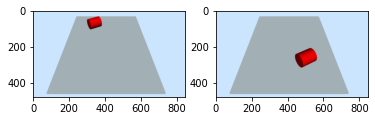

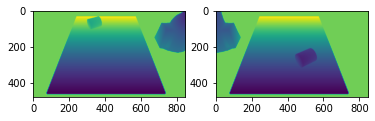

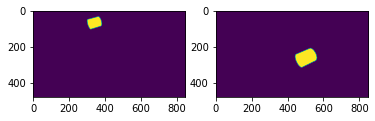

In [ ]:
# RGB image
back_rgb_im = project.get_back_rgb_im()
back_rgb_im = crop_out_arm(back_rgb_im, 'back')
front_rgb_im = project.get_front_rgb_im()
front_rgb_im = crop_out_arm(front_rgb_im, 'front')

plotting(front_rgb_im, back_rgb_im, 1)

# Depth image
back_depth_im = adjust_depth_image(project.get_back_depth_im())
front_depth_im = adjust_depth_image(project.get_front_depth_im())

plotting(front_depth_im, back_depth_im, 2)

# RGB image mask
front_mask = make_mask(front_rgb_im)
front_mask[0, 847] = False
back_mask = make_mask(back_rgb_im)

plotting(front_mask, back_mask, 3)

In [ ]:
# --- Generating point cloud of can using camera images ---
def image_to_points(project, depth_im):
    '''
    Projecting depth image data into pc points in camera frame.
    Adapted from 'normal_estimation_depth.ipynb' pset.
    :param depth_im: depth image
    :return: 1D array of point cloud points in camera frame
    '''
    # making each element in depth_pnts (index, depth)
    u_range = np.arange(depth_im.shape[0])
    v_range = np.arange(depth_im.shape[1])
    depth_v, depth_u = np.meshgrid(v_range, u_range)
    depth_pnts = np.dstack([depth_u, depth_v, depth_im])
    depth_pnts = depth_pnts.reshape([depth_pnts.shape[0]*depth_pnts.shape[1], 3])
    pC = project.project_depth_to_pC(depth_pnts)  # 1D array of point cloud point coords in camera frame
    return pC

def points_to_world_frame(pC, X_WC, mask=None):
    '''
    Projects point cloud points from camera frame to world frame. If a mask
    is specified, then only keep point cloud points correponding to pixels
    with value 1 in mask.
    :param pC: 1D list of point cloud points (n x 3)
    :param X_WC: transform of camera in world frame
    :param mask: True at pixel to keep in depth image and False otherwise (HAS TO BE BOOLEAN)
    :return: 1D array of point cloud points in world frame. (3 x m)
    '''
    if mask is None: return X_WC.multiply(pC)
    pC = pC.reshape(mask.shape + (3,))               # returning pC back into 2D array the size of mask
    can_pts_camera = pC[mask]                        # only want pc points corresponding to the can (m x 3)
    can_pts_world = X_WC.multiply(can_pts_camera.T)  # converting points to world frame (3 x m)
    return can_pts_world

# ------------------------------------------------------------------------------

front_can_pts_camera = image_to_points(project, front_depth_im)  # n x 3
front_can_pts_world = points_to_world_frame(front_can_pts_camera, project.front_cam_pose, front_mask)  # 3 x m
back_can_pts_camera = image_to_points(project, back_depth_im)
back_can_pts_world = points_to_world_frame(back_can_pts_camera, project.back_cam_pose, back_mask)

all_pts = np.concatenate((front_can_pts_world.T, back_can_pts_world.T))  # p x 3
# visualize_pointcloud(vis, pcl_np2drake(front_can_pts_world.T, [56, 186, 58]), name='pcl_can_front')
# visualize_pointcloud(vis, pcl_np2drake(back_can_pts_world.T , [0, 255, 255]), name='pcl_can_back')
visualize_pointcloud(vis, pcl_np2drake(all_pts , [56, 186, 58]), name='pcl_can')

### Normal Estimation ###

In [ ]:
def vis_normals(vis, normals, num=0):
    '''
    Adapted from 'normal_estimation_depth.ipynb' pset.
    :param num: value to start the normal vector naming at
    '''
    for i in range(len(normals)):
      name = 'normal_vec_{}'.format(i + num)
      AddTriad(vis=vis, name=name, prefix='', length=0.01, radius=0.001)
      vis[''][name].set_transform(normals[i].GetAsMatrix4())
    
def bbox(img):
    '''
    Adapted from 'normal_estimation_depth.ipynb' pset.
    '''
    a = np.where(img != 0)
    bbox = ([np.min(a[0]), np.max(a[0])], [np.min(a[1]), np.max(a[1])])
    return bbox

def estimate_normal_by_nearest_pixels(X_WC, mask, depth_im, pC, uv_step=10):
    """
    From 'normal_estimation_depth.ipynb' pset.
    Compute the surface normals from the nearest pixels (by a sliding window)
    Input:
        X_WC: RigidTransform of the camera in world frame
        mask: 1 at pixels that are represented as points in the point cloud
        depth_im: depth image from camera
        pC: 3D points computed from the depth image in the camera frame
        uv_step: recommended step size for the sliding window (see codes below)
    Output:
        normals: a list of RigidTransforms of the normal frames in world frame.
                 The +z axis of the normal frame is the normal vector, it should
                 points outward (towards the camera)
    """
    def get_index(image_index):
        # returns pC index (1D) from depth image index (2D)
        return image_index[0]*depth_im.shape[1] + image_index[1]

    normals = []
    u_bound, v_bound = bbox(mask)
    print("u_bound:", u_bound)
    print("v_bound:", v_bound)
    print("mask shape:", mask.shape)
    for u in range(u_bound[0], u_bound[1], uv_step):      # row
        for v in range(v_bound[0], v_bound[1], uv_step):  # column
            # center of the window at depth_im[u,v]
            center = [u,v]
            u_length = 3
            v_length = 3
            # side of the window
            u_range = np.arange(center[0] - u_length, center[0] + u_length+1)
            v_range = np.arange(center[1] - v_length, center[1] + v_length+1)
            ###################
            neighbors = pC[np.array([get_index([x,y]) for x in u_range for y in v_range])]
            pstar = np.mean(neighbors, axis=0)
            prel = neighbors - pstar
            W = np.matmul(prel.T, prel)
            w, V = np.linalg.eigh(W)
            # w is eigenvalues in ascending order, columns of V are corresponding eigenvectors
            # normal (z-axis) is the eigenvector with smallest eigenvalue
            # If the normal vector point n(u,v) has the same direction with the ray from camera to point pC(u,v), the normal should be flipped 
            camera_vector = pC[get_index(center)]  # camera in camera frame is the origin, so it's pC(u,v) - (0,0)
            if np.dot(camera_vector, V[:,0]) > 0:
                V[:,0] *= -1
            normals.append(X_WC.multiply(RigidTransform(RotationMatrix(np.fliplr(V)), camera_vector)))
            ###################
    return normals

# ------------------------------------------------------------------------------

front_normals = estimate_normal_by_nearest_pixels(project.front_cam_pose, front_mask, front_depth_im, front_can_pts_camera, uv_step=10)
back_normals = estimate_normal_by_nearest_pixels(project.back_cam_pose, back_mask, back_depth_im, back_can_pts_camera, uv_step=10)
# vis_normals(vis, front_normals, 0)
# vis_normals(vis, back_normals, len(front_normals))

u_bound: [36, 105]
v_bound: [300, 380]
mask shape: (480, 848)
u_bound: [211, 316]
v_bound: [439, 558]
mask shape: (480, 848)


### Antipodal Grasp ###

In [ ]:
# Confirm or deny: antipodal grasp will be composed of two normals, one front normals and one from back normals.
# It's never going to be two from front normals or two from back normals.

def antipodal_pairs(front_normals, back_normals, error=0.01):
    '''
    Gets all antipodal pairs of normals, where one is from the front normals list
    and the other is from the back normals list.
    :param front_normals: list of RigidTransform (from front camera)
    :param back_normals: list of RigidTransform (from back camera)
    :param error: threshold to be considered parallel vectors
    :return: list of antipodal pairs
    '''
    def is_invalid(normal):
        '''
        Checking if a normal is invalid.
        The normal vector should be vertical because a camera above the litter
        plate will never see a side of the object that could be antipodal to a
        vertical vector.
        Also discounting vectors too close to the ground because they normal
        vectors of the litter plate, not the can.
        :param normal: RigidTransform representing normal
        :return: boolean if invalid or not
        '''
        vertical = np.array([0, 0, 1])
        v = normal.rotation().multiply(vertical)
        is_vertical = np.abs(np.dot(v/np.linalg.norm(v), vertical/np.linalg.norm(vertical)) - 1) <= error
        is_on_ground = normal.translation()[-1] < 0.02
        return is_vertical or is_on_ground

    antipodal = []  # tuple pairs of antipodal normals
    vert = np.array([0, 0, 1])
    for f in front_normals:
        if is_invalid(f):
            continue
        f_vec = f.rotation().multiply(vert)
        for b in back_normals:
            if is_invalid(b):
                continue
            b_vec = b.rotation().multiply(vert)
            vec_between_normals = f.translation() - b.translation()
            if np.abs(np.dot(f_vec/np.linalg.norm(f_vec), b_vec/np.linalg.norm(b_vec)) - -1) <= error:  # normals are antipodal
                if np.abs(np.dot(f_vec/np.linalg.norm(f_vec), vec_between_normals/np.linalg.norm(vec_between_normals)) - 1) <= error:  # normals are across from each other 
                    antipodal.append([f, b])
    return np.array(antipodal)

# ------------------------------------------------------------------------------

antipodal = antipodal_pairs(front_normals, back_normals)
print(antipodal.shape)
antipodal_flat = np.array(list(set(antipodal.reshape((antipodal.size,)).tolist())))  # getting rid of duplicate normals
# print(antipodal_flat.shape)
# vis_normals(vis, antipodal_flat)

(24, 2)


In [ ]:
def vec_angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))

# the center of the can in the x-y plane should be the average of all antipodal pair normals
antipodal_positions = np.array([n.translation() for n in antipodal_flat])
grip_position = np.mean(antipodal_positions, axis=0)
# set the z coordinate to the highest normal which should be near the top of the can
# add a margin above can so gripper doesn't hit it
normal_positions = np.array([n.translation() for n in np.concatenate((front_normals, back_normals))])
grip_position[2] = np.max(normal_positions[:, 2]) + 0.04
print("grip position:", grip_position)

# finding rotation of gripper for grasp pose
distance_between_normals = np.array([[np.linalg.norm(n1.translation() - n2.translation()), n1, n2] for n1, n2 in antipodal])  # [distance, one normal]
distance_between_normals = np.array(sorted(distance_between_normals, key=lambda x: x[0]))
pair = distance_between_normals[len(distance_between_normals)//2] # choose a set of normals that are not the max distance apart but also not the min to avoid outliers
norm_vec = pair[2].rotation().multiply(np.array([0, 0, 1]))[:-1]  # using normal vector from back camera
norm_vec = norm_vec/np.linalg.norm(norm_vec)
if pair[0] < 0.098:  # if side normal, want to convert to a normal parallel to an end normal (if broken, use value < 0.098)
    if norm_vec[0] > 0:  # if the normal is pointing to the right
        norm_vec = np.dot(norm_vec, np.array([[np.cos(-np.pi/2), -np.sin(-np.pi/2)],[np.sin(-np.pi/2), np.cos(-np.pi/2)]]))
    else:
        norm_vec = np.dot(norm_vec, np.array([[np.cos(np.pi/2), -np.sin(np.pi/2)],[np.sin(np.pi/2), np.cos(np.pi/2)]]))

angle = vec_angle(norm_vec, np.array([0, 1]))

# We want the z-axis of the gripper to be parallel with normals of the ends of the can.
# Angle of normal vector from back camera w.r.t. y-axis ranges from -pi/2 to pi/2 but
# with an angle of -pi/2, arccos will return pi/2, so have to manually align the vectors.
rot_matrix = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
grip_vec = np.dot(np.array([0, 1]), rot_matrix)

print('norm vec:', norm_vec)
print('grip vec:', grip_vec)
print('angle between:', angle*180/np.pi, 'degrees')

if np.abs(np.dot(norm_vec, grip_vec) - 1) < 10**(-4):  # if they are not parallel, then rotated counterclockwise instead of clockwise
        print('was not parallel')
        angle *= -1

rot = RollPitchYaw(-np.pi/2, 0, angle)  # y-axis of gripper points down and yaw aligns with antipodal noramls
vis_normals(vis, pair[1:])

# ----- GRASP + PREGRASP -----
grasp_tf = RigidTransform(rot, grip_position)
pre_grasp_tf = RigidTransform(rot, grip_position + np.array([0, 0, 0.1]))
# ----------------------------

vis_normals(vis, [grasp_tf, pre_grasp_tf], 500)

grip position: [-0.59817895  0.19992202  0.13811659]
norm vec: [0.85853918 0.51274797]
grip vec: [0.85853918 0.51274797]
angle between: 59.1529551331667 degrees
was not parallel


NOTES:
- If don't want to rely on color for segmentation, can use RANSAC to remove plane (litter plate), convert point cloud points to depth image, then use blob detection (if no occluded images) to separate out elements in scene.
- Front mask ends up with a 'True' at [0, 847] ???
- Can easily have out of range errors (for depth mask) in normal estimation function

## Perception (multi can) ##

Strategy:
- Create separate masks for each can
- For each can: calculate surface normals and only keep the vertical ones that are far from the ground
    - The center of the can is the average position of the vertical normals in x-y plane
    - If the vertical normals are taller than 0.105, then the can is vertical. If shorter, then the can is on its side.
    - To calculate gripper pose:
        - For vertical can, a center position of can is sufficient
        - For sideways can, find vector between any two of the vertical normal positions. That vector is parallel to a normal of the end of the can. Use the same method as single can to calculate desired gripper rotation.

In [ ]:
# Setting up environment.
project_multi = Project()
vis_multi, initial_pose = project_multi.multi_object_environment()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://d624e4a0965a.ngrok.io/static/
Connected to meshcat-server.


/opt/drake/lib/python3.6/site-packages/pydrake/systems/meshcat_visualizer.py:426: DrakeDeprecationWarning: The pose_bundle input port is deprecated.  Use e.g.
builder.Connect(scene_graph.get_query_output_port(), visualizer.get_geometry_query_input_port())
instead. The deprecated code will be removed from Drake on or after 2021-03-01.
  "instead.", date="2021-03-01")


initial pose trans: [4.69565839e-01 2.95894043e-16 1.99196358e-01]


### Functions from Single Object Perception ###

In [ ]:
''' Point cloud utilities adapted from `pose_estimation_icp.ipynb` pset. '''
def pcl_np2drake(pcl_np, color):
    """
    Input: Nx3 np array of points in mm, and and 3x1 np array of color using uin8 format.
    Output: drake Pointcloud object. 
    """
    assert(pcl_np.shape[1] == 3) # sanity check. 
    pcl_drake = PointCloud(new_size = pcl_np.shape[0],
                           fields= Fields(BaseField.kXYZs | BaseField.kRGBs))
    xyzs = pcl_drake.mutable_xyzs()
    xyzs[:,:] = np.array(pcl_np).transpose()
    rgbs = pcl_drake.mutable_rgbs()
    rgbs[:,:] = np.tile(color, (pcl_np.shape[0], 1)).transpose()
    return pcl_drake

def visualize_pointcloud(vis, pcl, name="point_cloud", X_WC=RigidTransform()):
    """
    pcl: Drake pointcloud object. 
    All other formats should convert to this format before passing to visualization. 
    """
    vis[name].set_object(g.PointCloud(X_WC.multiply(pcl.xyzs()), pcl.rgbs() / 255., size=0.001))

def visualize_pointcloud_xyzrgb(vis, pcl_xyz, pcl_rgb, name="point_cloud", X_WC=RigidTransform()):
    """
    Visualization function to access Meshcat's method more directly. 
    """
    vis[name].set_object(g.PointCloud(X_WC.multiply(pcl_xyz), pcl_rgb / 255., size=0.001))

# ------------------------------------------------------------------------------

def plotting(im1, im2, fig_num):
    ''' Used for plotting side by side images (i.e. to show RGB image and its mask). '''
    plt.figure(fig_num)
    plt.subplot(1, 2, 1)
    plt.imshow(im1)
    plt.subplot(1, 2, 2)
    plt.imshow(im2)

def adjust_depth_image(im):
    ''' Processing on depth image. '''
    new_im = deepcopy(im)
    # the values of 690 are the distance from camera to plate x1000
    new_im = new_im/1000
    new_im[new_im >= 10] = 1  # attempting to filter out values out of range of depth camera
    return new_im

def make_mask(im):
    ''' Create mask from RGB image '''
    # plate_color = np.array([233, 246, 254, 255])  # approxmiate color of the plate with no shadow.
    u, v, w = im.shape
    flat_im = im.reshape((u*v,w))  # 1D array where each element is a color vector.
    # choosing all pixels that are not the plate color.
    # flat_mask = np.logical_not(np.logical_and(np.all(flat_im >= plate_color - 50, axis=1), np.all(flat_im <= plate_color + 50, axis=1)))
    flat_mask = np.logical_not(np.all(flat_im >= 100, axis=1))

    mask = flat_mask.reshape((u, v))
    # some points along the edge of the mask are shadows on the background (?) and they map to the
    # plate, not the can, so if the edges are eroded away, then these outliers won't be included.
    kernel = np.ones((3,3))
    erode = cv2.erode(np.array(mask, dtype='uint8'), kernel)
    mask = (erode == 1)
    return mask

# ------------------------------------------------------------------------------

def image_to_points(project, depth_im):
    '''
    Projecting depth image data into pc points in camera frame.
    Adapted from `normal_estimation_depth.ipynb`.
    :param depth_im: depth image
    :return: 1D array of point cloud points in camera frame
    '''
    # making each element in depth_pnts (index, depth)
    u_range = np.arange(depth_im.shape[0])
    v_range = np.arange(depth_im.shape[1])
    depth_v, depth_u = np.meshgrid(v_range, u_range)
    depth_pnts = np.dstack([depth_u, depth_v, depth_im])
    depth_pnts = depth_pnts.reshape([depth_pnts.shape[0]*depth_pnts.shape[1], 3])
    pC = project.project_depth_to_pC(depth_pnts)  # 1D array of point cloud point coords in camera frame
    return pC

def points_to_world_frame(pC, X_WC, mask=None):
    '''
    Projects point cloud points from camera frame to world frame. If a mask
    is specified, then only keep point cloud points correponding to pixels
    with value 1 in mask.
    :param pC: 1D list of point cloud points (n x 3)
    :param X_WC: transform of camera in world frame
    :param mask: True at pixel to keep in depth image and False otherwise (HAS TO BE BOOLEAN)
    :return: 1D array of point cloud points in world frame. (3 x m)
    '''
    if mask is None: return X_WC.multiply(pC)

    pC = pC.reshape(mask.shape + (3,))               # returning pC back into 2D array the size of mask
    can_pts_camera = pC[mask]                        # only want pc points corresponding to the can (m x 3)
    can_pts_world = X_WC.multiply(can_pts_camera.T)  # converting points to world frame (3 x m)
    return can_pts_world

# ------------------------------------------------------------------------------

def vis_normals(vis, normals, num=0):
    '''
    Adapted from `normal_estimation_depth.ipynb` pset.
    :param num: value to start the normal vector naming at.
    '''
    for i in range(len(normals)):
      name = 'normal_vec_{}'.format(i + num)
      AddTriad(vis=vis, name=name, prefix='', length=0.01, radius=0.001)
      vis[''][name].set_transform(normals[i].GetAsMatrix4())
    
def bbox(img):
    '''
    Adapted from `normal_estimation_depth.ipynb` pset.
    '''
    a = np.where(img != 0)
    bbox = ([np.min(a[0]), np.max(a[0])], [np.min(a[1]), np.max(a[1])])
    return bbox

def estimate_normal_by_nearest_pixels(X_WC, mask, depth_im, pC, uv_step=10):
    """
    Adapted from `normal_estimation_depth.ipynb` pset.
    Compute the surface normals from the nearest pixels (by a sliding window)
    :param X_WC:     RigidTransform of the camera in world frame
    :param mask:     1 at pixels that are represented as points in the point cloud
    :param depth_im: depth image from camera
    :parm pC:        3D points computed from the depth image in the camera frame
    :param uv_step:  recommended step size for the sliding window (see codes below)
    :return: normals -- a list of RigidTransforms of the normal frames in world frame.
                        The +z axis of the normal frame is the normal vector, it should
                        points outward (towards the camera)
    """
    def get_index(image_index):
        # returns pC index (1D) from depth image index (2D)
        return image_index[0]*depth_im.shape[1] + image_index[1]

    normals = []
    u_bound, v_bound = bbox(mask)
    print("u_bound:", u_bound)
    print("v_bound:", v_bound)
    print("mask shape:", mask.shape)
    for u in range(u_bound[0], u_bound[1], uv_step):      # row
        for v in range(v_bound[0], v_bound[1], uv_step):  # column
            # center of the window at depth_im[u,v]
            center = [u,v]
            u_length = 3
            v_length = 3
            # side of the window
            u_range = np.arange(center[0] - u_length, center[0] + u_length+1)
            v_range = np.arange(center[1] - v_length, center[1] + v_length+1)
            ###################
            neighbors = pC[np.array([get_index([x,y]) for x in u_range for y in v_range])]
            pstar = np.mean(neighbors, axis=0)
            prel = neighbors - pstar
            W = np.matmul(prel.T, prel)
            w, V = np.linalg.eigh(W)
            # w is eigenvalues in ascending order, columns of V are corresponding eigenvectors
            # normal (z-axis) is the eigenvector with smallest eigenvalue
            # If the normal vector point n(u,v) has the same direction with the ray from camera to point pC(u,v), the normal should be flipped 
            camera_vector = pC[get_index(center)]  # camera in camera frame is the origin, so it's pC(u,v) - (0,0)
            if np.dot(camera_vector, V[:,0]) > 0:
                V[:,0] *= -1
            normals.append(X_WC.multiply(RigidTransform(RotationMatrix(np.fliplr(V)), camera_vector)))
            ###################
    return normals
    
# ------------------------------------------------------------------------------

def antipodal_pairs(front_normals, back_normals, error=0.01):
    '''
    Gets all antipodal pairs of normals, where one is from the front normals list
    and the other is from the back normals list.
    :param front_normals: list of RigidTransform (from front camera)
    :param back_normals: list of RigidTransform (from back camera)
    :param error: threshold to be considered parallel vectors
    :return: list of antipodal pairs
    '''
    def is_invalid(normal):
        '''
        Checking if a normal is invalid.
        The normal vector should be vertical because a camera above the litter
        plate will never see a side of the object that could be antipodal to a
        vertical vector.
        Also discounting vectors too close to the ground because they normal
        vectors of the litter plate, not the can.
        :param normal: RigidTransform representing normal
        :return: boolean if invalid or not
        '''
        vertical = np.array([0, 0, 1])
        v = normal.rotation().multiply(vertical)
        is_vertical = np.abs(np.dot(v/np.linalg.norm(v), vertical/np.linalg.norm(vertical)) - 1) <= error
        is_on_ground = normal.translation()[-1] < 0.02
        return is_vertical or is_on_ground

    antipodal = []  # tuple pairs of antipodal normals
    vert = np.array([0, 0, 1])
    for f in front_normals:
        if is_invalid(f):
            continue
        f_vec = f.rotation().multiply(vert)
        for b in back_normals:
            if is_invalid(b):
                continue
            b_vec = b.rotation().multiply(vert)
            vec_between_normals = f.translation() - b.translation()
            if np.abs(np.dot(f_vec/np.linalg.norm(f_vec), b_vec/np.linalg.norm(b_vec)) - -1) <= error:  # normals are antipodal
                if np.abs(np.dot(f_vec/np.linalg.norm(f_vec), vec_between_normals/np.linalg.norm(vec_between_normals)) - 1) <= error:  # normals are across from each other 
                    antipodal.append([f, b])
    return np.array(antipodal)

### Capture Images (top camera) ###

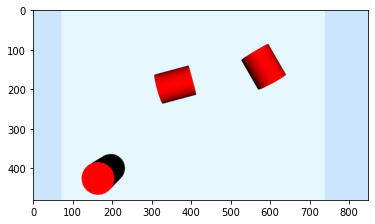

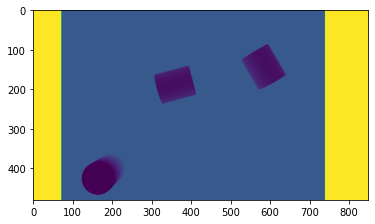

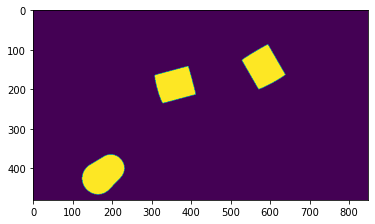

In [ ]:
# RGB image
top_rgb_im = project_multi.get_top_rgb_im()

plt.figure(1)
plt.imshow(top_rgb_im)

# Depth image
top_depth_im = adjust_depth_image(project_multi.get_top_depth_im())

plt.figure(2)
plt.imshow(top_depth_im)

# RGB image mask
top_mask = make_mask(top_rgb_im)
top_mask[0, 847] = False

plt.figure(3)
plt.imshow(top_mask)

### Multi-object Segmentation ###


mask shape: (480, 848)


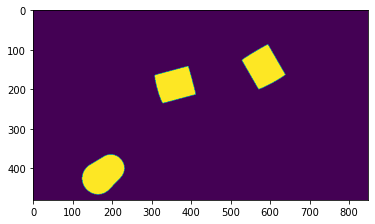

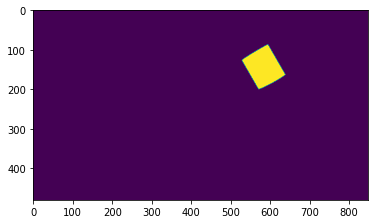

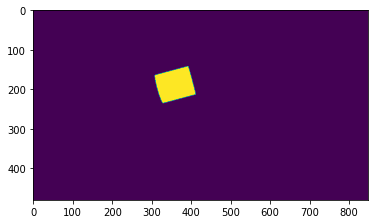

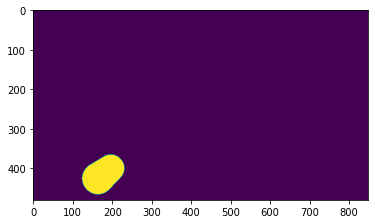

In [ ]:
def segment_multi_object(all_mask):
    '''
    Takes in a mask with potentially multiple objects and produces a separate
    mask for each object. Assumes no two objects are touching in mask or else
    they will be considered one single object.
    :param all_mask: image where a pixel of 1 (True) is of an object, else 0 (False)
    :return: a list of masks (dtype='bool') for each object in original mask
    '''
    mask = deepcopy(all_mask)
    print('mask shape:', mask.shape)

    def valid_index(index):
        # checks if index is out of bounds of mask.
        return 0 <= index[0] < mask.shape[0] and 0 <= index[1] < mask.shape[1]

    def check_neighbors(index):
        # returns indices of neighbors (left, right, top, bottom) that are also 1.
        neighbor_indicies = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]]) + np.array(index)
        return {tuple(i) for i in neighbor_indicies if (valid_index(i) and mask[tuple(i)] == 1)}

    def segment_one_object():
        # returns all indicies belonging to one object.
        r, c = np.where(mask == 1)
        initial = (r[0], c[0])  # pick any index that is a 1 and expand out until all connecting 1s are found
        o_indicies = {initial}
        neighbors_to_check = [initial]
        while neighbors_to_check:
            next = neighbors_to_check.pop()
            neighbors = check_neighbors(next)
            neighbors_to_check += [n for n in neighbors if n not in o_indicies]
            o_indicies.update(neighbors)
        return np.array(list(o_indicies))

    masks = []
    while len(np.where(mask == 1)[0]) != 0:  # while there are still objects in the mask
        indicies = segment_one_object().T
        single_mask = np.zeros(mask.shape, dtype='bool')
        single_mask[indicies[0], indicies[1]] = True
        masks.append(single_mask)
        mask[indicies[0], indicies[1]] = 0  # remove found object from original mask

    return masks

# SMALL TEST CASE:
# top_mask = np.array([[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
#                      [0,0,1,1,0,1,0,0,0,0,0,1,1,1,0],
#                      [0,0,1,1,1,1,0,0,0,0,0,0,1,1,0],
#                      [0,0,1,1,0,0,0,1,1,0,0,0,1,1,0],
#                      [0,0,0,1,0,0,1,0,1,1,0,1,1,0,0],
#                      [0,0,0,0,0,1,1,0,1,1,0,1,1,0,0],
#                      [0,0,0,0,0,1,1,1,1,1,0,0,1,0,0],
#                      [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
# plt.figure(0)
# plt.imshow(top_mask)
# masks = segment_multi_object(top_mask)
# for i in range(len(masks)):
#     plt.figure(i+1)
#     plt.imshow(masks[i])

plt.figure(0)
plt.imshow(top_mask)
top_masks = segment_multi_object(top_mask)
for i in range(len(top_masks)):
    plt.figure(i+1)
    plt.imshow(top_masks[i])

In [ ]:
# point clouds associated with cans
top_can_pts_camera = image_to_points(project_multi, top_depth_im)  # n x 3 (407040 x 3)
can_pts_world = [points_to_world_frame(top_can_pts_camera, project_multi.top_cam_pose, mask).T for mask in top_masks]

all_pts = np.concatenate(can_pts_world)
visualize_pointcloud(vis_multi, pcl_np2drake(all_pts , [56, 186, 58]), name='pcl_cans')

### Normal Estimation ###

In [ ]:
top_normals = [estimate_normal_by_nearest_pixels(project_multi.top_cam_pose, mask, top_depth_im, top_can_pts_camera, uv_step=10) for mask in top_masks]
# vis_normals(vis_multi, np.concatenate(top_normals), 0)

u_bound: [87, 199]
v_bound: [529, 638]
mask shape: (480, 848)
u_bound: [142, 234]
v_bound: [308, 411]
mask shape: (480, 848)
u_bound: [365, 465]
v_bound: [124, 231]
mask shape: (480, 848)


In [ ]:
def filter_normals(normals, error=0.01):
    '''
    Only want to keep normals that are vertical are not near the ground.
    :param normals: list all surface normals.
    :param error: threshold to be considered vertical
    :return: list of normals that are vertical and off the ground.
    '''
    valid = []
    vertical = np.array([0, 0, 1])
    for normal in normals:
        v = normal.rotation().multiply(vertical)
        is_vertical = np.abs(np.dot(v/np.linalg.norm(v), vertical/np.linalg.norm(vertical)) - 1) <= error
        is_on_ground = normal.translation()[-1] < 0.02
        if is_vertical and (not is_on_ground):
            valid.append(normal)
    return np.array(valid)

vertical_normals = [filter_normals(normals) for normals in top_normals]
# vis_normals(vis_multi, np.concatenate(vertical_normals), 0)

### Determining Grasp Poses ###

In [ ]:
def vec_angle(v1, v2):  # angle between vectors.
    return np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))

# The center of the can in the x-y plane should be the average of all vertical normal positions.
normal_positions = [np.array([n.translation() for n in normals]) for normals in vertical_normals]
grip_positions = np.array([np.mean(positions, axis=0) for positions in normal_positions])
# Set the z coordinate to the highest normal which should be near the top of the can.
offset = 0.02  # add a margin above can so gripper doesn't hit it
for i in range(len(grip_positions)):
    grip_positions[i][2] = np.max(normal_positions[i][:, 2]) + offset
print("grip position:", grip_positions)

# Determining if the can is vertical or horizontal.
# True = vertical, False = horizontal
orientations = [p[2] >= 0.105 + offset for p in grip_positions]
print("orientations:", orientations)

# Finding rotation of gripper for grasp pose.
#  - For vertical can, a center position of can is sufficient (any rotation in x-y plane can pick up can).
#  - For horizontal can, the linear regression through vertical normal positions in x-y plane is parallel
#    to the normals on the ends of the can. Use same method single can to find gripper pose rotation.
rotations = []
for i in range(len(normal_positions)):
    if orientations[i]:  # vertical can
        rotations.append(RollPitchYaw(-np.pi/2, 0, 0))
    else:
        m, b = np.polyfit(normal_positions[i].T[0], normal_positions[i].T[1], 1)
        norm_vec = np.array([1, m])
        norm_vec = norm_vec/np.linalg.norm(norm_vec)  # parallel to normal from end of can

        angle = vec_angle(norm_vec, np.array([0, 1]))
        
        # We want the z-axis of the gripper to be parallel with normals of the ends of the can.
        # Angle of normal vector from back camera w.r.t. y-axis ranges from -pi/2 to pi/2 but
        # with an angle of -pi/2, arccos will return pi/2, so have to manually align the vectors.
        rot_matrix = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
        grip_vec = np.dot(np.array([0, 1]), rot_matrix)

        print('norm vec:', norm_vec)
        print('grip vec:', grip_vec)
        print('angle between:', angle*180/np.pi, 'degrees')

        if np.abs(np.dot(norm_vec, grip_vec) - 1) < 10**(-4):  # Ff they are not parallel, then rotated counterclockwise instead of clockwise.
            print('was not parallel')
            angle *= -1
        
        rot = RollPitchYaw(-np.pi/2, 0, angle)  # y-axis of gripper points down and yaw aligns with antipodal noramls.
        rotations.append(rot)

# ----- GRASP + PREGRASP -----
grasps = []  # (grasp_tf, pre_grasp_tf)
for i in range(len(rotations)):
    grasps.append((RigidTransform(rotations[i], grip_positions[i]),
                   RigidTransform(rotations[i], grip_positions[i] + np.array([0, 0, 0.1]))))
grasps = np.array(grasps)
# ----------------------------

vis_normals(vis_multi, grasps.reshape((grasps.shape[0]*grasps.shape[1],)), 500)

grip position: [[-0.59632567  0.19973616  0.118     ]
 [-0.55038999 -0.04493492  0.118     ]
 [-0.30061824 -0.25031617  0.131     ]]
orientations: [False, False, True]
norm vec: [0.88689551 0.46197008]
grip vec: [0.88689551 0.46197008]
angle between: 62.485693677567426 degrees
was not parallel
norm vec: [ 0.40614758 -0.9138075 ]
grip vec: [ 0.40614758 -0.9138075 ]
angle between: 156.0369398440271 degrees
was not parallel


## Motion Planning ##

Strategy: 
1. For each can, pass through `pre_grasp`, `grasp`, `aboveplate`, `midframe`, `abovebin`, and release
2. Optimization-based inverse kinematics (given end effector trajectory (poses), `MathematicalProgram()` solves for joint trajectory), subject to joint constraints (max velocities etc), positional and rotational deviations from nominal trajectory
<!--  $\min ||q-q_{desired}||_2^2$ s.t. conditions... -->

#### Initialization

In [ ]:
def visualize_transform(vis, name, transform, prefix='', length=0.1, radius=0.006, opacity=0.1):
    # Support RigidTransform as well as 4x4 homogeneous matrix.
    if isinstance(transform, RigidTransform):
        transform = transform.GetAsMatrix4()
    AddTriad(vis, name=name, prefix=prefix, length=length, radius=0.005, opacity=opacity)
    vis[prefix][name].set_transform(transform)

# ------------------------------------------------------------------------------

# Pre-determined frames.
abovebin = RigidTransform(RollPitchYaw(-np.pi/2, 0, 0), [1, 0, 0.5])
midframe = RigidTransform(RollPitchYaw(0, 0, 0), [0, 0.5, 0.3])
aboveplate = RigidTransform(RollPitchYaw(-np.pi/2, 0, 0), [-0.5, 0, 0.3])
grasp_tfs, pre_grasp_tfs = grasps.T

visualize_transform(vis_multi, 'midframe', midframe, opacity=0.8)
visualize_transform(vis_multi, 'abovebin', abovebin, opacity=0.8)
visualize_transform(vis_multi, 'aboveplate', aboveplate, opacity=0.8)

### Determining Joint Positions ###
Given keypoints, interpolate a trajectory, and translate to joint poses.

The majority of the following code is adapted from the `door_opening.ipynb` pset.

In [ ]:
# door_opening code, also grasping cylinder and solving for a trajectory given constraints using prog = MathematicalProgram();
def CreateIiwaControllerPlant():
    """creates plant that includes only the robot and gripper, used for controllers."""
    robot_sdf_path = FindResourceOrThrow(
        "drake/manipulation/models/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf")
    gripper_sdf_path = FindResourceOrThrow(
        "drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf")
    sim_timestep = 1e-3
    plant_robot = MultibodyPlant(sim_timestep)
    parser = Parser(plant=plant_robot)
    parser.AddModelFromFile(robot_sdf_path)
    parser.AddModelFromFile(gripper_sdf_path)
    plant_robot.WeldFrames(
        A=plant_robot.world_frame(),
        B=plant_robot.GetFrameByName("iiwa_link_0"))
    plant_robot.WeldFrames(
        A=plant_robot.GetFrameByName("iiwa_link_7"),
        B=plant_robot.GetFrameByName("body"),
        X_AB=RigidTransform(RollPitchYaw(np.pi / 2, 0, np.pi / 2), np.array([0, 0, 0.114]))
    )
    plant_robot.mutable_gravity_field().set_gravity_vector([0, 0, 0])
    plant_robot.Finalize()

    link_frame_indices = []
    for i in range(8):
        link_frame_indices.append(
            plant_robot.GetFrameByName("iiwa_link_" + str(i)).index())

    return plant_robot, link_frame_indices

def make_gripper_orientation_trajectory(t_start, t_end, tf_start, tf_end):
    '''Interpolates between two orientations for given time range.'''
    traj = PiecewiseQuaternionSlerp()
    traj.Append(t_start, tf_start.rotation())
    traj.Append(t_end, tf_end.rotation())
    return traj

def make_gripper_position_trajectory(t_start, t_end, tf_start, tf_end):
    '''Interpolates between two translations for give time range.'''
    traj = PiecewisePolynomial.FirstOrderHold(
        [t_start, t_end],
        np.vstack([[tf_start.translation()],
                   [tf_end.translation()]]).T)
    return traj

def make_gripper_trajectory(t_start, t_end, tf_start, tf_end):
    rot = make_gripper_orientation_trajectory(t_start, t_end, tf_start, tf_end)
    trans = make_gripper_position_trajectory(t_start, t_end, tf_start, tf_end)
    return rot, trans

'''
Timestamps for 'recycling' one can:
  - 0-5: aboveplate - pregrasp
  - 5-10: pregrasp - grasp
  - 10-13: close gripper
  - 13-18: grasp - aboveplate
  - 18-24: aboveplate - midframe
  - 24-30: midframe - abovebin
  - 30-33: open gripper
  - 33-39: abovebin - midframe
  - 39-45: midframe - aboveplate
'''

def InterpolatePoseEntry(t, rot_traj, trans_traj):
    return RigidTransform(RotationMatrix(rot_traj.value(t)), trans_traj.value(t))

# Wrapper function for end-effector pose. Total time per cycle: 7 seconds.
def InterpolatePoseInit(t, init_pose, aboveplate, midframe, abovebin):
    if (t < 5.0):
        rot, trans = make_gripper_trajectory(0.0, 5.0, init_pose, midframe)
        return InterpolatePoseEntry(t, rot, trans)
    # elif (t >= 5.0) and (t < 10.0):
    #     rot, trans = make_gripper_trajectory(5.0, 10.0, abovebin, midframe)
    #     return InterpolatePoseEntry(t, rot, trans)
    elif (t >= 5.0):
        rot, trans = make_gripper_trajectory(5.0, 15.0, midframe, aboveplate)
        return InterpolatePoseEntry(t, rot, trans)

# Wrapper function for end-effector pose. Total time per cycle: 18 seconds.
def InterpolatePose(t, pre_grasp, grasp, aboveplate, midframe, abovebin):
    if (t < 5.0):
        rot, trans = make_gripper_trajectory(0.0, 5.0, aboveplate, pre_grasp)
        return InterpolatePoseEntry(t, rot, trans)
    elif (t >= 5.0) and (t < 10.0):
        rot, trans = make_gripper_trajectory(5.0, 10.0, pre_grasp, grasp)
        return InterpolatePoseEntry(t, rot, trans)
    elif (t >= 10.0) and (t < 13.0):
        # Wait for a second to grip the can.
        rot, trans = make_gripper_trajectory(5.0, 10.0, pre_grasp, grasp)
        return InterpolatePoseEntry(10.0, rot, trans)
    elif (t >= 13.0) and (t < 18.0):
        rot, trans = make_gripper_trajectory(13.0, 18.0, grasp, aboveplate)
        return InterpolatePoseEntry(t, rot, trans)
    elif (t >= 18.0) and (t < 24.0):
        rot, trans = make_gripper_trajectory(18.0, 24.0, aboveplate, midframe)
        return InterpolatePoseEntry(t, rot, trans)
    elif (t >= 24.0) and (t < 30.0):
        rot, trans = make_gripper_trajectory(24.0, 30.0, midframe, abovebin)
        return InterpolatePoseEntry(t, rot, trans)
    elif (t >= 30.0) and (t < 33.0):
        # Wait for a second to release the can.
        rot, trans = make_gripper_trajectory(24.0, 30.0, midframe, abovebin)
        return InterpolatePoseEntry(30.0, rot, trans)
    elif (t >= 33.0) and (t < 39.0):
        rot, trans = make_gripper_trajectory(33.0, 39.0, abovebin, midframe)
        return InterpolatePoseEntry(t, rot, trans)
    elif (t >= 39.0):
        rot, trans = make_gripper_trajectory(39.0, 45.0, midframe, aboveplate)
        return InterpolatePoseEntry(t, rot, trans)


def create_q_knots(pose_lst):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant, _ = CreateIiwaControllerPlant()
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName("body")
    q_nominal = np.array([-2.25623770e-12, 4.37698706e-01, 1.71337848e-11, -1.27662123e+00,
                          -1.20890032e-11, 7.29497844e-01, 2.13672825e-12, 0, 0])  # joint positions corresponding to intial pose

    # nominal joint for joint-centering, just for initial step

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame, R_AbarA=R_WG,
            frameBbar=gripper_frame, R_BbarB=RotationMatrix(),
            theta_bound=bounds
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame, frameB=gripper_frame, p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower, p_AQ_upper=p_WG_upper)

    for i in range(len(pose_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        if i == 0:
            prog.SetInitialGuess(q_variables, q_nominal)
        else:
            prog.SetInitialGuess(q_variables, q_knots[-1])
        pos = pose_lst[i].translation()
        rot = pose_lst[i].rotation()
        
        if (0 <= (t_lst[i]-15)%len_cycle <= 14): 
          # in every cycle, when the gripper gets close to the can, reduce tolerance
          tol = 0
          AddPositionConstraint(ik, pos + np.array([-tol,-tol, 0]), pos + np.array([tol,tol,0]))
          AddOrientationConstraint(ik, rot, 0.1)
        else:
          tol = 0.1
          AddPositionConstraint(ik, pos + np.array([-tol,-tol,-tol]), pos + np.array([tol,tol,tol]))

        result = Solve(prog)

        if not result.is_success():
            raise RuntimeError
        
        q_knots.append(result.GetSolution(q_variables))

    return q_knots

### `MathematicalProgram()` and Inverse Kinematics

In [ ]:
len_cycle = 45
n_iters = int(np.size(grasps,0))
t_end = 15 + len_cycle * n_iters
t_lst = np.linspace(0, t_end, 3*t_end)

# Create gripper trajectory.
gripper_t_lst = [0.0]
gripper_knots = [0.107]
pose_lst = []
for iter in range(n_iters):
  gripper_t_lst.extend([15+iter*len_cycle+i for i in (10.,12.,30.,33.)])
  gripper_knots.extend([0.107, 0., 0.,0.107])
gripper_t_lst = np.array(gripper_t_lst)
gripper_knots = np.array(gripper_knots).reshape(1,len(gripper_knots))

for t in t_lst:
  if t < 15:
    pose = InterpolatePoseInit(t,initial_pose,aboveplate,midframe,abovebin)
  else:
    iter = int((t-15)//len_cycle)
    iter = iter if iter < n_iters else int(n_iters-1)
    pose = InterpolatePose(t-15-iter*len_cycle, pre_grasp_tfs[iter], grasp_tfs[iter], aboveplate, midframe, abovebin)
  
#   visualize_transform(vis_multi, str(t), pose)
  pose_lst.append(pose)


######################################################################
# # ONE CAN ONLY
# grasp_tf, pre_grasp_tf = grasps[0]
# # Visualize our end-effector nominal trajectory.
# t_lst = np.linspace(0, 60, 60*3)
# pose_lst = []
# for t in t_lst:
#     if t < 15:
#         pose = InterpolatePoseInit(t,initial_pose,aboveplate,midframe,abovebin)
#     else:
#         pose = InterpolatePose(t-15,pre_grasp_tf,grasp_tf,aboveplate,midframe,abovebin)

#     visualize_transform(vis_multi, str(t), pose, opacity=0.1)
#     pose_lst.append(pose)

# # Create gripper trajectory.
# gripper_t_lst = np.array([0.,25.,27.,45.,48.,60.])
# gripper_knots = np.array([0.107, 0.107, 0., 0.,0.107,0.107]).reshape(1,6)
#######################################################################

g_traj = PiecewisePolynomial.FirstOrderHold(gripper_t_lst, gripper_knots)

q_knots = np.array(create_q_knots(pose_lst))
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)

proj = Project()
vis, simulator, plant, diagram = proj.build_and_simulate_trajectory_environment(q_traj, g_traj)
simulator.AdvanceTo(0.1)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://d624e4a0965a.ngrok.io/static/
Connected to meshcat-server.


/opt/drake/lib/python3.6/site-packages/pydrake/systems/meshcat_visualizer.py:426: DrakeDeprecationWarning: The pose_bundle input port is deprecated.  Use e.g.
builder.Connect(scene_graph.get_query_output_port(), visualizer.get_geometry_query_input_port())
instead. The deprecated code will be removed from Drake on or after 2021-03-01.
  "instead.", date="2021-03-01")


In [ ]:
# Run simulation.
simulator.AdvanceTo(t_end)

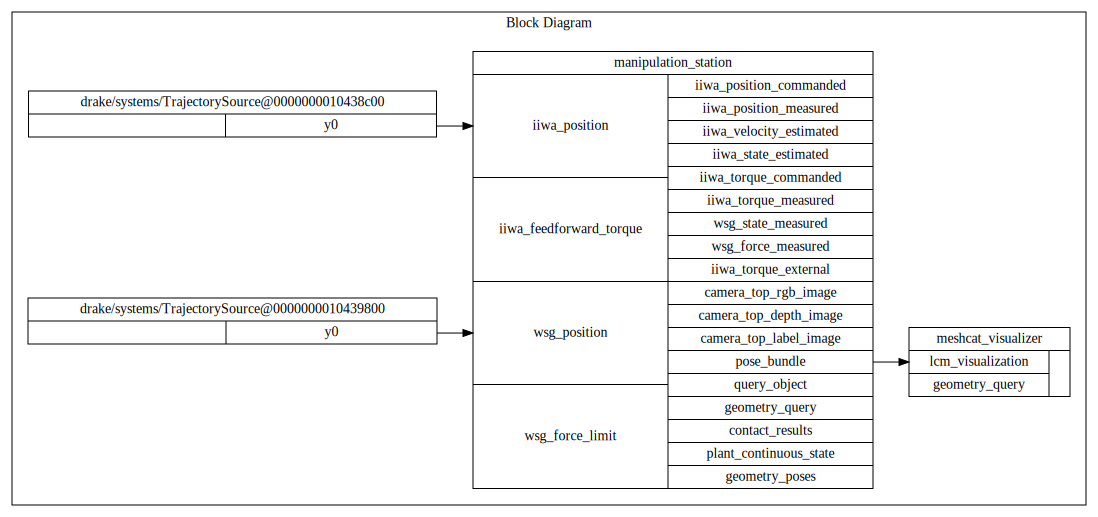

In [ ]:
diagram.set_name("Block Diagram")
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=1))[0].create_svg())